# Introduction

In [72]:
import os
import sys
import datetime
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt

from tsfresh import extract_features
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Activation, Dense, concatenate, LSTM, GRU
from sklearn import metrics
from sklearn.svm import SVC

# Data Importation

In [12]:
dfx = pd.read_csv('../data/x_train.csv').set_index('ID')
dfy = pd.read_csv('../data/y_train.csv').set_index('ID')
dfx_test = pd.read_csv('../data/x_test.csv').set_index('ID')

In [13]:
dfy.head()
dfx_test.tail()

,neuron_id,timestamp_0,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,...,timestamp_40,timestamp_41,timestamp_42,timestamp_43,timestamp_44,timestamp_45,timestamp_46,timestamp_47,timestamp_48,timestamp_49
ID,,,,,,,,,,,,,,,,,,,,,
28599,9456,1.501446,1.935893,2.100466,2.144410,2.259503,2.269867,2.292989,2.346420,2.724702,...,20.970412,20.984293,20.997030,21.016212,21.039446,21.044450,21.277555,21.723172,22.037007,22.061580
28600,10064,0.059309,0.116247,0.163038,0.262012,0.301379,1.813054,2.068066,2.168285,2.232430,...,21.518761,22.137357,22.504569,23.102718,23.155953,23.254136,23.302653,23.480564,23.539625,23.585673
28601,10045,0.563164,1.563625,1.677879,1.881264,2.583920,2.948714,3.112856,3.299712,6.040656,...,22.736962,22.842219,22.905865,22.971377,22.982869,23.614314,23.650248,23.807894,24.425525,25.271358
28602,9570,1.052182,1.066127,1.805688,1.824387,1.864275,2.420648,2.431845,2.757334,3.235232,...,35.510581,35.700678,37.062503,37.789828,38.569837,39.213227,41.504263,41.963118,41.983141,42.038623
28603,9836,0.004843,0.026412,0.033590,0.307083,0.311297,0.426553,0.449229,0.453311,1.199124,...,17.048710,17.993623,18.675683,18.827421,18.847187,18.923304,18.929989,19.166302,19.362858,19.370905


In [14]:
if dfy.shape[0] == dfx.shape[0]:
    print("Same number of samples, all good.")
else:
    print("Different number of samples, problem!")

Same number of samples, all good.


# Data Exploration

* **Sanity check:** diff etat1/etat2, neuron_id usefulness

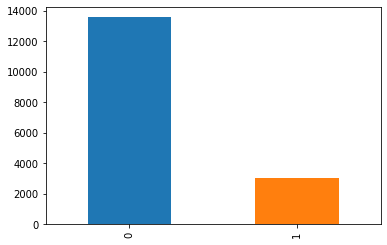

In [15]:
# Différence entre le nombre d'etats 1 et d'etats 0.
dfy.TARGET.value_counts().plot(kind='bar')
plt.show()

In [16]:
# Should we keep the neuron_id col ?
xtest_uniques = dfx_test.neuron_id.unique()
x_uniques = dfx.neuron_id.unique()
diff = [x for x in x_uniques if x in xtest_uniques]
print("There are {} neuron_ids in common between the train and test sets.".format(len(diff)))

There are 1 neuron_ids in common between the train and test sets.


* **Balance dataset:** Under-sample class2 to have same number of samples in both classes

In [17]:
# SET SEED pour reproducibilité

def undersample(X, y):
    """ Return balanced training dataset obtained by undersampling class 2. """
    # Extract class2 indices from Y
    y_class1_ix = np.where(y == 1)[0]
    y_class2_ix = np.where(y == 0)[0]
    
    # Under-sample class2 to get balanced classes
    y_class2_ix_undersampled = np.random.choice(y_class2_ix, len(y_class1_ix))

    # Concatenate the undersampled_class2_array and the class1_array
    balanced_ix = np.concatenate((y_class1_ix, y_class2_ix_undersampled), axis=0)
    np.random.shuffle(balanced_ix)
    
    # Create X_train dataset (Keras will do the val split)
    X_train = X[balanced_ix]
    y_train = y[balanced_ix]
    
    """ DEPRECATED:
    # Create **UNOFFICIAL** X_test containing only 0s.
    balanced_ix_test = np.in1d(range(X.shape[0]), balanced_ix)
    X_test = X[~balanced_ix_test]
    y_test = y[~balanced_ix_test]"""
    
    return X_train, y_train

* **Extract features:** Use tsfresh to perform feature engineering

In [18]:
# WIP !
def extract_tsfresh(dfx):
    dfx = pd.DataFrame(dfx.stack(), columns=['spike_time']).reset_index()
    extracted_features = extract_features(dfx, column_id="ID", column_value="spike_time", column_sort="level_1")
    dfx = dfx.pivot(index='ID', columns='level_1', values='spike_time')
    dfx.columns = [int(col[col.find('_') + 1:]) for col in dfx.columns]
    dfx = dfx.sort_index(axis=1).join(extracted_features)
    dfx = dfx.dropna(axis='columns')
    fname = "../data/features{}.csv".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    dfx.to_csv(fname, sep=',')
    return dfx

In [19]:
def get_save(fn):
    save = pd.read_csv(fn)
    save = save.dropna(axis='columns').set_index('ID')
    return save

In [63]:
def isolate_features(X):
    ts_arr = X[:,:50]
    fe_arr = X[:,50:]
    fe_arr = np.reshape(fe_arr, fe_arr.shape[:-1])
    """
    Obsolete: repeat engineered features for each 50 timestep of a sample
    X = np.concatenate((np.repeat(features_arr.transpose(0,2,1), 50, axis=1), nofeat_arr), axis=2)
    !!! Will kill 42's mac !!!
    """
    return ts_arr, fe_arr

In [46]:
def drop_unique_col(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col,inplace=True,axis=1)

* **Standardization:** Scale features

In [58]:
def standardize_data(X):
    """Simple standardization that accepts both a single arr, AND 2 arrays in case of RNN+FeatureEngineering"""
    def standardize(X):
        X -= np.mean(X, axis=0)
        X /= (np.std(X, axis=0) + sys.float_info.epsilon)
        X = np.nan_to_num(X)
        return X

    if len(X) > 1:
        X = (X[0], standardize(X[1]))
    else:
        X = standardize(X)
    return X

* **Create Xtrain ytrain:** numpy array from df, with dimensions *(sample_nb, timestep_nb, feature_nb)*

In [94]:
def getData(dfx, dfy, 
            exclude_neuron_id=True, 
            balancing="undersample",
            standardize=False,
            differencing=False,
            get_tsfresh=False,
            get_ISI_SPIKE=False,
            testing=False,
            RNN=True,
            **extras):    
   
    fe_arr = 0
    if isinstance(dfx, str) and get_tsfresh:
        dfx = get_save(dfx)
        drop_unique_col(dfx)
    else:
        if exclude_neuron_id:
            # X: Exclude neuron_id column from array
            dfx = dfx.drop(columns=['neuron_id'])
        if get_tsfresh:
            dfx = extract_tsfresh(dfx)
    
    X = dfx.values
    
    X = X[..., np.newaxis]
    y = np.reshape(dfy.values, (dfy.values.shape[0],))
       
    if balancing == "undersample" and not testing:
        X, y = undersample(X, y)
        
    # Convert from timeseries to interval
    if differencing:
        X[:,1:50] -= X[:,:49]
 
    if get_ISI_SPIKE:
        pass
    
    if get_tsfresh:
        X = isolate_features(X)
#    elif get_tsfresh:
#        X = np.reshape(X, X.shape[:2])
        
    if standardize:
        X = standardize_data(X)
      
    return X, y

* **Deprecated:** Concatenate neuron_id to every timestep of a sample 

In [49]:
# TODO : Make a 3d numpy array from our pandas df
# Shape = [samples, timestamps, features]
"""
timesteps_arr = dfx.iloc[:,1:].values
timesteps_arr = timesteps_arr[..., np.newaxis]
timesteps_arr.shape

neuron_arr = dfx.iloc[:,0].values
neuron_arr.shape

neuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)
final_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)
final_arr.shape
"""

'\ntimesteps_arr = dfx.iloc[:,1:].values\ntimesteps_arr = timesteps_arr[..., np.newaxis]\ntimesteps_arr.shape\n\nneuron_arr = dfx.iloc[:,0].values\nneuron_arr.shape\n\nneuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)\nfinal_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)\nfinal_arr.shape\n'

# Model Training

## References

* Arxiv: [Neural activity classification with machine learning models trained oninterspike interval series data](https://arxiv.org/pdf/1810.03855.pdf) => PCA and KNN
* Github: [PySpike: Python library to analyze spike Train](https://github.com/mariomulansky/PySpike) => Obscure mathematical measurements between spike trains
* Profil: [Prof expert en spike train analysis](http://xtof.perso.math.cnrs.fr/)

## Prepare experiment

In [95]:
params = {
    'name': "RF_vanilla",
    'exclude_neuron_id': True,
    'balancing': "undersample",
    'standardize': True,
    'differencing': True,
    'get_tsfresh': True,
    'get_ISI_SPIKE': False,
    'RNN': False
}

In [96]:
if params['get_tsfresh']:
    X_train, fe_arr_train, y_train = getData("../data/features0607182541.csv", dfy, **params)
    X_test, fe_arr_test, _ = getData("../data/features0607183651.csv", dfy, testing=True, **params)
    print(X_train.shape, fe_arr_train.shape)
else:
    X_train, y_train = getData(dfx, dfy, **params)
    X_test, _ = getData(dfx_test, dfy, testing=True, **params)
    print(X_train.shape, X_test.shape)

In [84]:
def predict(X_test, model):
    # Predict on custom X_test
    y_pred = model.predict(X_test)
    y_pred = np.reshape(y_pred, (y_pred.shape[0],))
    print (y_pred.shape)
    # Convert sigmoid output to 0s and 1s
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
  
    # Format .csv in ENS style
    dfy_pred = pd.DataFrame(data=y_pred, columns=["TARGET"], dtype=int)
    dfy_pred.index.name = "ID"
    dfy_pred.index += 16635
    return dfy_pred

## Run training

### Deep-Learning 1: blunt RNN

* **Create and train model**

In [78]:
"""
timestamp_nb = X_train.shape[1]
feature_nb = X_train.shape[2]
params['cell_nb'] = 128

input_shape = (timestamp_nb, feature_nb)
x = input_tensor = Input(input_shape)
x = LSTM(params['cell_nb'], return_sequences=False)(x)
x = output_tensor = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, output_tensor)
model.summary()
"""

timestep_nb = X_train.shape[1]
spike_per_ts = 1
params['cell_nb'] = 128

input_tensor = Input(shape=(timestep_nb, spike_per_ts))
X = LSTM(params['cell_nb'], return_sequences=False)(input_tensor)

if params['get_tsfresh']:
    additional_features = fe_arr_train.shape[1]
    fe_input = Input(shape=(additional_features,)) # A tensor containing the engineered features
    latent = Dense(32, activation='tanh')(fe_input)
    input_tensor = [input_tensor, fe_input]
    X = concatenate([X, latent])   
    
output_tensor = Dense(1, activation='sigmoid')(X)

model = Model(input_tensor, output_tensor)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 382)          0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 128)          66560       input_20[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 32)           12256       input_21[0][0]                   
__________________________________________________________________________________________________
concatenat

In [80]:
model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
history = model.fit([X_train, fe_arr_train], y_train, epochs=10, validation_split=0.1)

Train on 5504 samples, validate on 612 samples
Epoch 1/10
5504/5504 [==============================] - 25s 5ms/step - loss: 0.2177 - acc: 0.6532 - val_loss: 0.2351 - val_acc: 0.6242
Epoch 2/10
5504/5504 [==============================] - 22s 4ms/step - loss: 0.2148 - acc: 0.6588 - val_loss: 0.2416 - val_acc: 0.6160
Epoch 3/10
5504/5504 [==============================] - 22s 4ms/step - loss: 0.2117 - acc: 0.6644 - val_loss: 0.2444 - val_acc: 0.5899
Epoch 4/10
5504/5504 [==============================] - 22s 4ms/step - loss: 0.2087 - acc: 0.6702 - val_loss: 0.2369 - val_acc: 0.6176
Epoch 5/10
5504/5504 [==============================] - 23s 4ms/step - loss: 0.2059 - acc: 0.6835 - val_loss: 0.2425 - val_acc: 0.5948
Epoch 6/10
5504/5504 [==============================] - 21s 4ms/step - loss: 0.2035 - acc: 0.6835 - val_loss: 0.2388 - val_acc: 0.6062
Epoch 7/10
5504/5504 [==============================] - 21s 4ms/step - loss: 0.2011 - acc: 0.6924 - val_loss: 0.2381 - val_acc: 0.6095
Epoch 8/

In [82]:
history_params = [
    ('batch_size', history.params['batch_size']),
    ('epochs', history.params['epochs']),
    ('samples', history.params['samples']),
    ('val_acc', history.history['val_acc'][-1])
    ]

for param in history_params:
    params[param[0]] = param[1]

* **Predict**

In [85]:
dfy_pred = predict([X_test, fe_arr_test], model)
dfy_pred[:5]

(11969,)


,TARGET
ID,
16635,1
16636,0
16637,0
16638,1
16639,1
16640,0
16641,1
16642,0
16643,0


### Domain-knowledge 1: Benchmark = differencing + tsfresh feature engineering + random forest

* **Train**

In [100]:
clf = SVC(gamma='auto')
clf.fit(fe_arr_train, y_train)
params.update(clf.get_params())

* **Predict**

In [101]:
dfy_pred = predict(fe_arr_test, clf)

(11969,)


### Domain-knowledge 2: KNN with SPIKE- and ISI- synchronization distances

## Save Results

In [102]:
def saveExp(dfy_pred, model, params):
    """ Create directory in which to save predictions, experiment parameters and model object. """

    directory = "../experiments/{}".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    if not os.path.exists(directory):
        os.makedirs(directory)

    dfy_pred.to_csv(directory + '/y_pred.csv', sep=',')
    
    model.save(directory + '/model.h5')
    
    columns = []
    values = []
    for k, v in params.items():
        columns.append(k)
        values.append(v)
    params_df = pd.DataFrame(data=[values], columns=columns)
    params_df.to_csv(directory + '/params.csv', sep=';')
    return directory

# Save model
saveExp(dfy_pred, model, params)

'../experiments/0612180411'